In [1]:
!tree -dL 2 input/

input/

0 directories


In [2]:
# generic librairies
import time as time
import numpy as np
import pandas as pd
import gc

# Text librairies
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tag.util import untag
import contractions
# import pycontractions # Alternative better package for removing contractions
from autocorrect import Speller


from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mglearn
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
#plt.rc('axes', prop_cycle=(
#    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
#    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']

# Load Data

In [3]:
%%time

# https://numpy.org/devdocs/user/basics.types.html

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str', 'Body': 'str', 'Text': 'str'}

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=['Id', 'Score', 'Title', 'Body','Text'], 
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=10000
                          )

CPU times: user 125 ms, sys: 8.38 ms, total: 133 ms
Wall time: 132 ms


In [4]:
df_questions

,Id,Title,Body,Score,Text
0,5649407,string array python,long string represent series value type conver...,182,string array python long string represent seri...
1,7974849,make one python file run another,make one python file run another example two p...,355,make one python file run another make one pyth...
2,29554796,mean band width ggplot geomsmooth lm,follow code libraryggplot ggplotmtcars aesxwt ...,32,mean band width ggplot geomsmooth lm follow co...
3,250151,lua generalpurpose script language,see thing ever read embed often anything world...,36,lua generalpurpose script language see thing e...
4,1342000,make python interpreter correctly character st...,string look like way string understand python ...,104,make python interpreter correctly character st...
...,...,...,...,...,...
9995,16561362,check result set,statement return hit example tab want check ro...,56,check result set statement return hit example ...
9996,20501345,initialize data frame lot time r,find initialize data frame dimension like df d...,28,initialize data frame lot time r find initiali...
9997,8804830,python multiprocessing picklingerror pickle,sorry reproduce error simpler example code com...,289,python multiprocessing picklingerror pickle so...
9998,4754383,change metadata object amazon,already object amazon bucket change metadata u...,35,change metadata object amazon already object a...


In [5]:
text_train = df_questions.Text
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'pandas.core.series.Series'>
length of text_train: 10000
text_train[6]:
python count element object match attribute try find way count number object match criterion eg class person def initself age gender selfname name selfage age selfgender gender list people peoplelist f personhenry personmarg f function count number object match argument base attribute return persongender f personage


# Representer le texte en "Bag of Words"

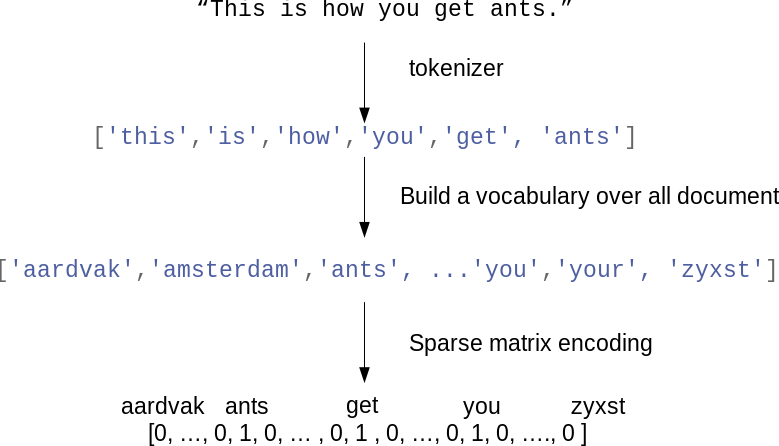

In [6]:
# faire un test de bag of words

bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [8]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [9]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [10]:
print("Dense representation of bag_of_words:\n{}".format(
    bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


## bag-of-words de Post

In [11]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<10000x51550 sparse matrix of type '<class 'numpy.int64'>'
	with 337043 stored elements in Compressed Sparse Row format>


In [12]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 5010 to 5030:\n{}".format(feature_names[5010:5030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 51550
First 20 features:
['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaadwpwaaaaaaaabaaaaaaaaaceaaaaaaaaaqqaaaaaaaabraaaaaaaaageaaaaaaaaacqaaaaaaaacbaaaaaaaaaikaaaaaaaaakqaaaaaaaaczaaaaaaaaakeaaaaaaaaaqqaaaaaaaacxaaaaaaaaalkaaaaaaaaawqaaaaaaaadfaaaaaaaaamkaaaaaaaaazqaaaaaaaadraaaaaaaaanuaaaaaaaaaqaaaaaaaaddaaaaaaaaaoea', 'aaaab', 'aaaabbcccdddddd', 'aaaarghxxx', 'aaab', 'aaabbb', 'aaabbcc', 'aaabcabccd', 'aaah', 'aaarg', 'aaaxxx', 'aab', 'aababcbac']
Features 5010 to 5030:
['catanimal', 'catastrophe', 'catastrophically', 'catastrophizing', 'catb', 'catblah', 'catcaaaabbaaaabbb', 'catch', 'catchconfigerror', 'catcher', 'catching', 'catchment', 'catchmentsize', 'catchout', 'catchoutn', 'catdefault', 'categoiesk', 'categoricalboth', 'categories', 'categorize']
Every 2000th feature:
['aa', 'artistname', 'bof', 'classone', 'cprogram', 'dbdbname', 'domainoperations', 'exportclassesmle', 'framefr

## bag-of-word avec plus d'un mot (n-grams)

In [13]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [14]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [15]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [16]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [17]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


# Modélisation automatique des sujets

## LDA, Latent Dirichlet Allocation
L'objectif de ce type de modélisation de sujets est de récupérer de potentielles catégories pour des traitements ultérieurs. Cette modélisation offre surtout une meilleure compréhension de la structuration du texte en vue de création de features manuelles (mettre l'accent sur certains mots, comprendre ce qui définit une catégorie, etc.)


Assuming symmetric Dirichlet distributions (for simplicity), a low alpha (doc_topic_prior) value places more weight on having each document composed of only a few dominant topics (whereas a high value will return many more relatively dominant topics). Similarly, a low beta (topic_word_prior) value places more weight on having each topic composed of only a few dominant words.

If all the αk have values lower than unit the maximum is found at corners

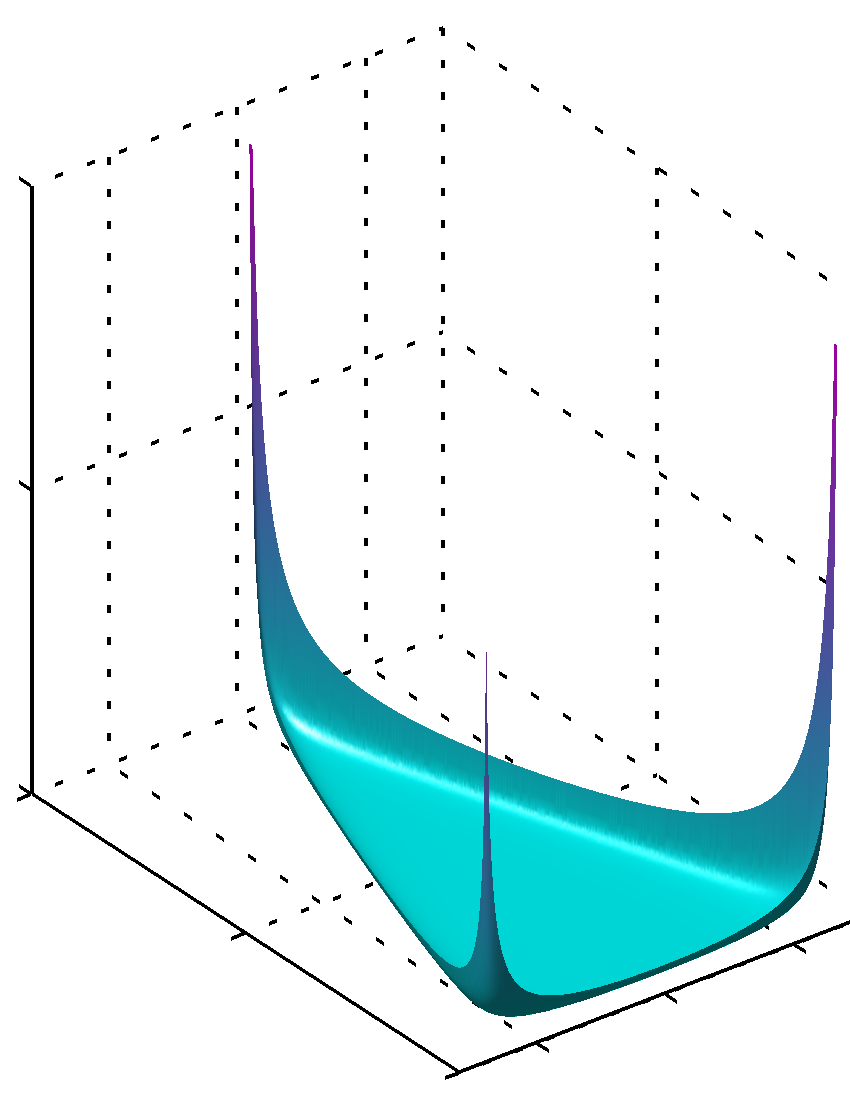

or can if all values αk are the same and greater than 1 the maximum will be found in center like
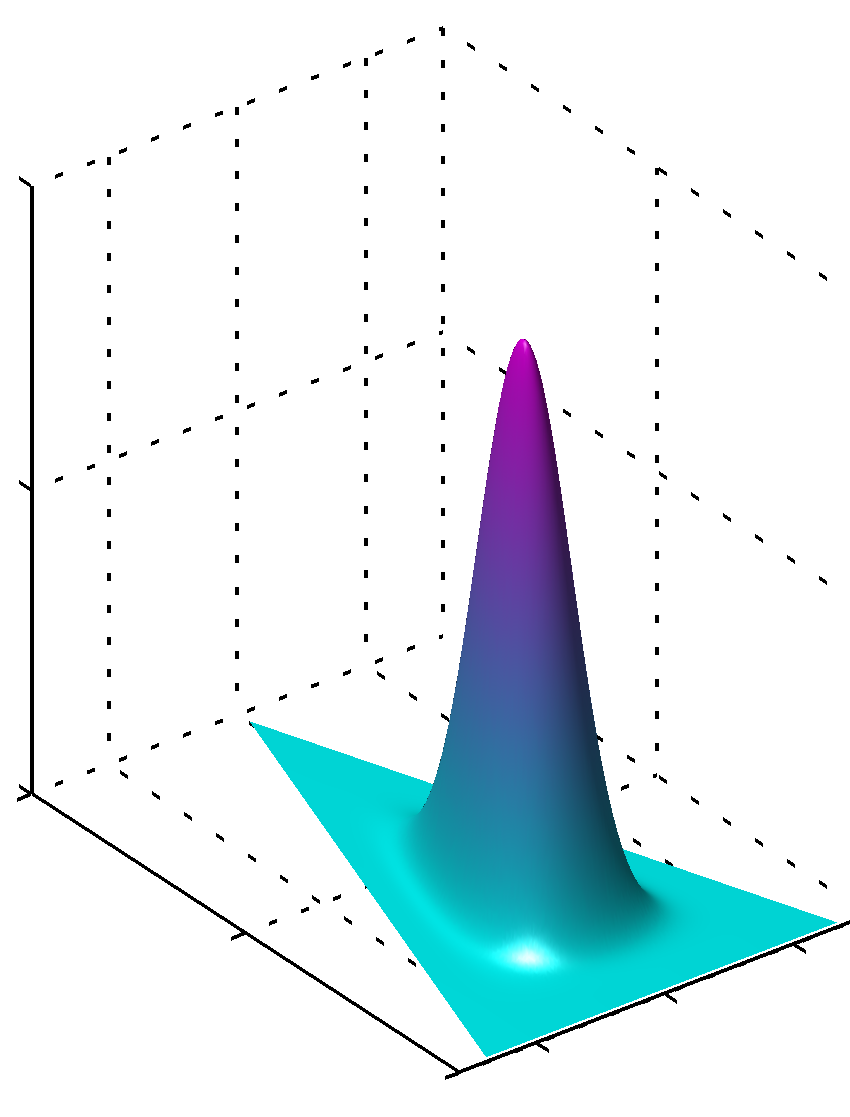


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

no_features = 10000


#tfidf_vectorizer = TfidfVectorizer( max_df=0.15,  min_df=2,  max_features=no_features)

#X = tfidf_vectorizer.fit_transform(text_train)
#feature_names = np.array(tfidf_vectorizer.get_feature_names())



vect = CountVectorizer(max_features=no_features, max_df=.15)
X = vect.fit_transform(text_train)


# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold (corpus-specific
    stop words).

In [19]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=0.005, # a low alpha --> each document composed of only a few dominant topics
                                topic_word_prior=0.005,  # a low betha --> each topic composed of only a few dominant words
                                learning_method="online",
                                learning_offset=50.,
                                max_iter=25,
                                random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [20]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


In [21]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

In [22]:
#fonction du livre introduction_to_ml_with_python-master

def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [23]:
# Print out the 10 topics:

print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=2, n_words=5)

topic 0       topic 1       
--------      --------      
pti           run           
pm            line          
rd            script        
dbl           import        
watch         package       


topic 2       topic 3       
--------      --------      
na            log           
world         memory        
num           directory     
column        level         
ff            folder        


topic 4       topic 5       
--------      --------      
column        list          
row           string        
array         print         
number        date          
name          character     


topic 6       topic 7       
--------      --------      
error         plot          
package       ggplot        
database      image         
member        label         
warn          color         


topic 8       topic 9       
--------      --------      
class         time          
def           group         
import        count         
name          key           
call  

In [24]:
lda20 = LatentDirichletAllocation(n_components=20, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics20 = lda20.fit_transform(X)

In [25]:
sorting = np.argsort(lda20.components_, axis=1)[:, ::-1]

print_topics(topics=range(20), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=8, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       
--------      --------      --------      --------      --------      --------      --------      --------      
image         django        group         task          row           date          plot          point         
output        server        number        thread        name          model         ggplot        matrix        
id            request       count         filter        bar           time          label         plot          
save          database      float         form          foo           field         color         import        
html          application   sum           share         csv           day           size          matplotlib    
document      app           difference    process       var           class         set           array         
chunk         memory        output        queue         column        datetime      line        

In [26]:
# sort by weight of "function" topic 3
function = np.argsort(document_topics20[:, 3])[::-1]
# print the five documents where the topic is most important
for i in function[:5]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

r calculate odds ratio regression trouble interpret result regression outcome decision take take product respectively thoughts negative round point want probability take product change thought change regression equation glmdecision thought family data data accord model thought probability decision b p determine odds ratio decision function thought expcoefresults odds ratio question interpret odds ratio odds ratio increase decrease thought affect odds take take product imply thought increase decrease odds take take product increase decrease approximately unit convert odds ratio thought estimate probability decision estimate probability decision thought score calculate estimate probability take product thought.

confidence interval prediction regression r predictlm compute prediction base result regression also offer confidence interval prediction accord interval base error variance fit error interval hand predictglm computes prediction base poisson regression amongst others option confi

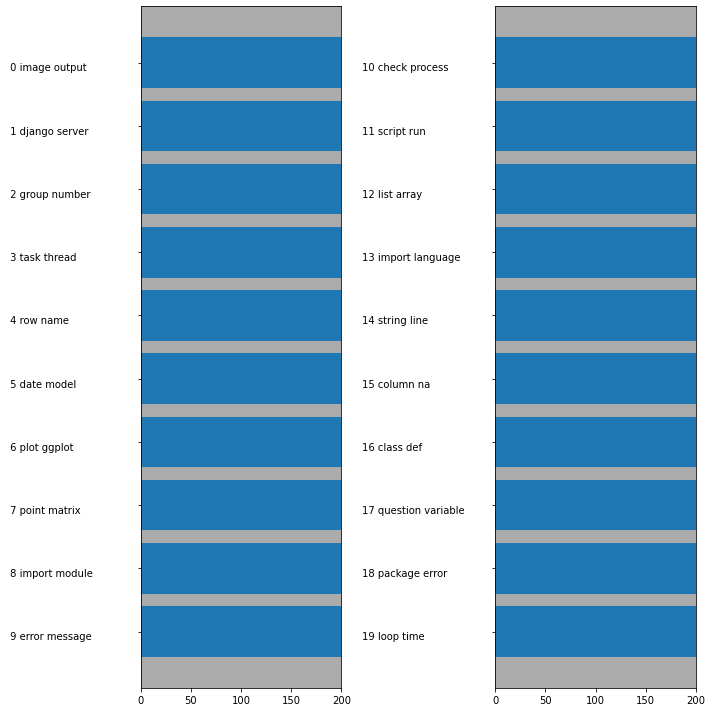

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), np.sum(document_topics20, axis=0)[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 200)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')


In [28]:
### Utiliser le modèle LDA entrainé pour faire des prédictions et proposer des nouveaux mots
#catégoriser nouvelles entrés avec le modèle entrainé
#new_post = ['I love this movie and never get tired of watching. The music in it is great.']
new_post = [text_train[35]] # test sur des post du dataset
new_post_vect = vect.transform(new_post)
post_topics20 = lda20.transform(new_post_vect)
rating = np.sort(post_topics20[0,:])[::-1][:2]
tag = np.argsort(post_topics20[0,:])[::-1][:2]
print(new_post[0])
print(rating)
print_topics(topics=tag, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=5)

destroywindow close mac use python opencv program generates series windows use follow code def displayimg name fun click cvshowimagename img cvsetmousecallbackname fun img cvwaitkey click cvshowimagename img cvdestroywindowname press q within gui window close however code continue call display function display gui window closing first use run program terminal windows thanks
[0.615 0.235]
topic 11      topic 0       
--------      --------      
script        image         
run           output        
directory     id            
window        save          
path          html          




## NMF - No-Negative Matrix Factorisation

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

no_features = 10000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=no_features, 
    stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(text_train)
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

nmf_topics = nmf.transform(tfidf)

no_top_words = 5

sorting_nmf = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(topics=range(10), feature_names=tfidf_feature_names,
                           sorting=sorting_nmf, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
python        list          column        class         string        
use           element       data          def           character     
way           item          row           method        convert       
code          index         value         instance      python        
run           value         frame         initself      remove        
like          sort          dataframe     object        like          
script        way           na            attribute     split         
print         tuples        df            model         number        
work          comprehension vector        return        way           
time          want          like          print         format        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
file

In [30]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join(
            [feature_names[i] for i in topic.argsort()[::-1][:no_top_words]]))

display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0:
python use way code run
Topic 1:
list element item index value
Topic 2:
column data row value frame
Topic 3:
class def method instance initself
Topic 4:
string character convert python remove
Topic 5:
file line read directory error
Topic 6:
plot ggplot label matplotlib color
Topic 7:
function return def argument parameter
Topic 8:
array element numpy index matrix
Topic 9:
import module importerror error initpy


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

no_features = 10000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=no_features, 
    stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(text_train)
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

no_topics = 20

# Run NMF
nmf_20 = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_20.fit(tfidf)

nmf_topics_20 = nmf_20.transform(tfidf)

no_top_words = 5

sorting_nmf_20 = np.argsort(nmf_20.components_, axis=1)[:, ::-1]
print_topics(topics=range(20), feature_names=tfidf_feature_names,
                           sorting=sorting_nmf_20, topics_per_chunk=8, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       
--------      --------      --------      --------      --------      --------      --------      --------      
python        list          column        class         string        file          plot          function      
use           element       row           def           character     directory     ggplot        return        
script        item          dataframe     method        convert       read          label         def           
way           index         df            initself      remove        path          matplotlib    argument      
code          sort          matrix        instance      split         csv           color         parameter     
like          comprehension panda         object        like          write         legend        use           
run           tuples        columns       attribute     python        folder        axis        

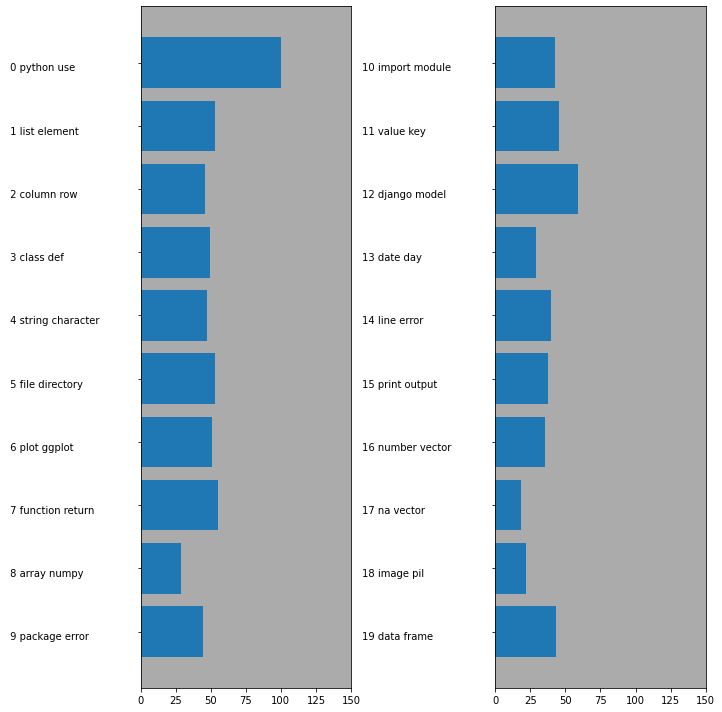

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(tfidf_feature_names[sorting_nmf_20[:, :2]])]
# two column bar chart:

for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), np.sum(nmf_topics_20, axis=0)[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 150)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')


In [33]:
### Utiliser le modèle NMF entrainé pour faire des prédictions et proposer des nouveaux mots
#catégoriser nouvelles entrés avec le modèle entrainé
#new_post = ['I love this movie and never get tired of watching. The music in it is great.']
new_post = [text_train[25]] # test sur des post du dataset
new_post_vect = tfidf_vectorizer.transform(new_post)
post_topics100 = nmf.transform(new_post_vect)
rating = np.sort(post_topics100[0,:])[::-1][:2]
tag = np.argsort(post_topics100[0,:])[::-1][:2]
print(new_post[0])
print(rating)
print_topics(topics=tag, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=5)

way apply filter pandas series scenario user want apply filter pandas series object essentially want efficiently chain filtering comparison operation together specify user filter additive aka one result currently use reindex creates time copy underlie data documentation correctly could really inefficient filter series dataframe think use apply something might better pretty pandas though still try head around everything tldr want take follow form apply operation give series object return filter series object relops long example example currently filter series object function currently use applyrelopsseries relops pass relational operator perform give series object op vals relopsiteritems opsop val vals filter opfuncseries series seriesreindexseriesfiltered series user provide operation want perform df pandasdataframecol col print df print df col col operator import le ops ge applyrelopsdfcol col name col applyrelopsdfcol relops name col problem approach think lot possibly copy data step

In [34]:
from sklearn.manifold import TSNE

vect = CountVectorizer(max_features=10000, max_df=.15)
X_tsne = vect.fit_transform(text_train)

tsne5 = TSNE(n_components=2, random_state=42,perplexity=5, n_jobs=-1)
tsne50 = TSNE(n_components=2, random_state=42,perplexity=50, n_jobs=-1)
df_reduced_tsne5 = tsne5.fit_transform(X_tsne)
# df_reduced_tsne50 = tsne50.fit_transform(X)

In [35]:
tSNE_perplexity = 't-SNE perplexity=5'

df_reduced_tsne = df_reduced_tsne5
df_reduced_tsne.shape

(10000, 2)

In [36]:
y_pred_lda = lda.transform(X)
y_pred_nmf = nmf.transform(tfidf)
y_pred_lda

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.996, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.602, 0.   , 0.396],
       ...,
       [0.069, 0.365, 0.   , ..., 0.   , 0.296, 0.   ],
       [0.   , 0.998, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.078, 0.756, 0.   ]])

In [37]:
tag_lda = np.argsort(y_pred_lda[:,:],axis=1)[:,::-1][:,:1]
score_lda = np.sort(y_pred_lda[:,:],axis=1)[:,::-1][:,:2]


In [38]:
tag_nmf = np.argsort(y_pred_nmf[:,:],axis=1)[:,::-1][:,:1]
score_nmf = np.sort(y_pred_nmf[:,:],axis=1)[:,::-1][:,:2]


In [39]:
LDA_sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
NMF_sorting = np.argsort(nmf.components_, axis=1)[:, ::-1]

In [40]:
LDA_catétories_Tags = []
for i in range(LDA_sorting.shape[0]):
    LDA_catétories_Tags.append([feature_names[LDA_sorting[i,0]],
                            feature_names[LDA_sorting[i,1]],
                            feature_names[LDA_sorting[i,2]],
                            feature_names[LDA_sorting[i,3]],
                            ])
print( 'Liste des Topics LDA')
for i in range(LDA_sorting.shape[0]):
    print('Topic ',i,' : ',LDA_catétories_Tags[i])

Liste des Topics LDA
Topic  0  :  ['pti', 'pm', 'rd', 'dbl']
Topic  1  :  ['run', 'line', 'script', 'import']
Topic  2  :  ['na', 'world', 'num', 'column']
Topic  3  :  ['log', 'memory', 'directory', 'level']
Topic  4  :  ['column', 'row', 'array', 'number']
Topic  5  :  ['list', 'string', 'print', 'date']
Topic  6  :  ['error', 'package', 'database', 'member']
Topic  7  :  ['plot', 'ggplot', 'image', 'label']
Topic  8  :  ['class', 'def', 'import', 'name']
Topic  9  :  ['time', 'group', 'count', 'key']


In [41]:
NMF_catétories_Tags = []
for i in range(NMF_sorting.shape[0]):
    NMF_catétories_Tags.append([tfidf_feature_names[NMF_sorting[i,0]],
                            tfidf_feature_names[NMF_sorting[i,1]],
                            tfidf_feature_names[NMF_sorting[i,2]],
                            tfidf_feature_names[NMF_sorting[i,3]],
                            ])
print( 'Liste des Topics NMF')
for i in range(NMF_sorting.shape[0]):
    print('Topic ',i,' : ',NMF_catétories_Tags[i])


Liste des Topics NMF
Topic  0  :  ['python', 'use', 'way', 'code']
Topic  1  :  ['list', 'element', 'item', 'index']
Topic  2  :  ['column', 'data', 'row', 'value']
Topic  3  :  ['class', 'def', 'method', 'instance']
Topic  4  :  ['string', 'character', 'convert', 'python']
Topic  5  :  ['file', 'line', 'read', 'directory']
Topic  6  :  ['plot', 'ggplot', 'label', 'matplotlib']
Topic  7  :  ['function', 'return', 'def', 'argument']
Topic  8  :  ['array', 'element', 'numpy', 'index']
Topic  9  :  ['import', 'module', 'importerror', 'error']


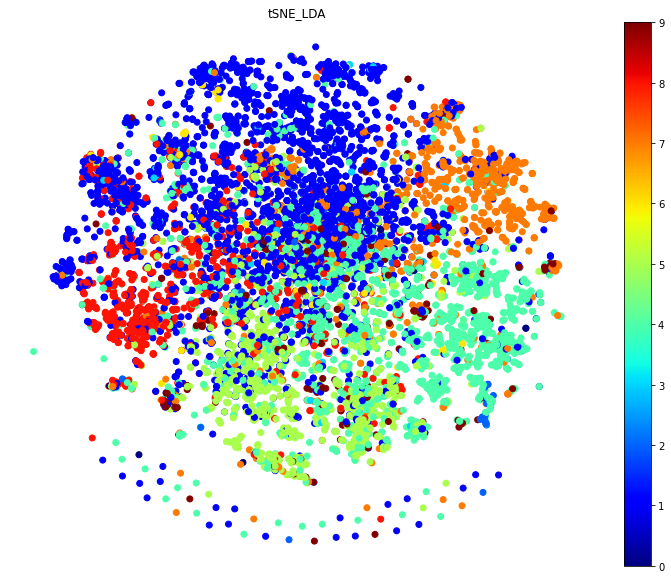

In [42]:
fig = plt.figure(figsize=(13, 10))
fig.patch.set_facecolor('w')
#plt.figure(figsize=(13, 10))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=tag_lda, cmap="jet")
plt.title('tSNE_LDA')
plt.axis('off')
plt.colorbar()
plt.show()

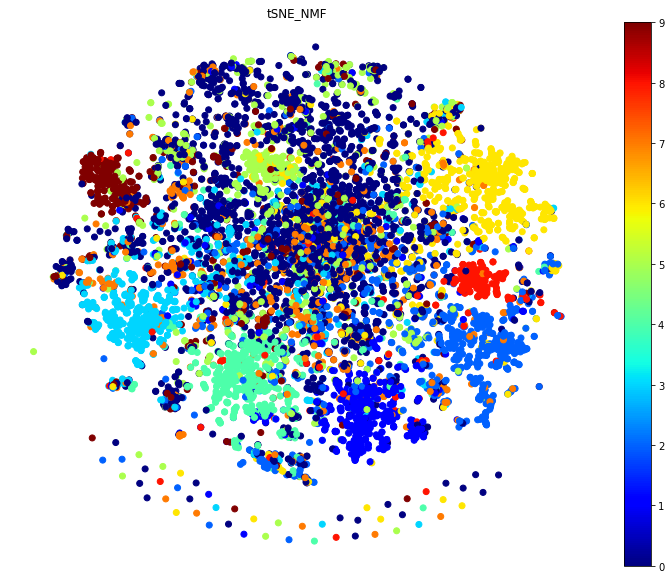

In [43]:
fig = plt.figure(figsize=(13, 10))
fig.patch.set_facecolor('w')
#plt.figure(figsize=(13, 10))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=tag_nmf, cmap="jet")
plt.title('tSNE_NMF')
plt.axis('off')
plt.colorbar()
plt.show()


In [44]:
color_lda = np.zeros(tag_lda.shape)
for i in range(len(color_lda)):
    if tag_lda[i]==7:
        color_lda[i]=1
        
color_nmf = np.zeros(tag_lda.shape)
for i in range(len(color_nmf)):
    if tag_nmf[i]==0:
        color_nmf[i]=1

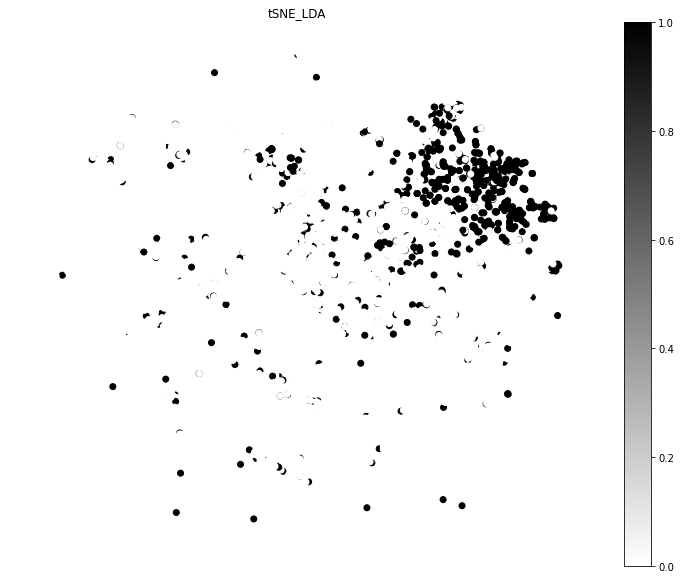

In [45]:
fig = plt.figure(figsize=(13, 10))
fig.patch.set_facecolor('w')
#plt.figure(figsize=(13, 10))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=color_lda, cmap="binary")
plt.title('tSNE_LDA')
plt.axis('off')
plt.colorbar()
plt.show()

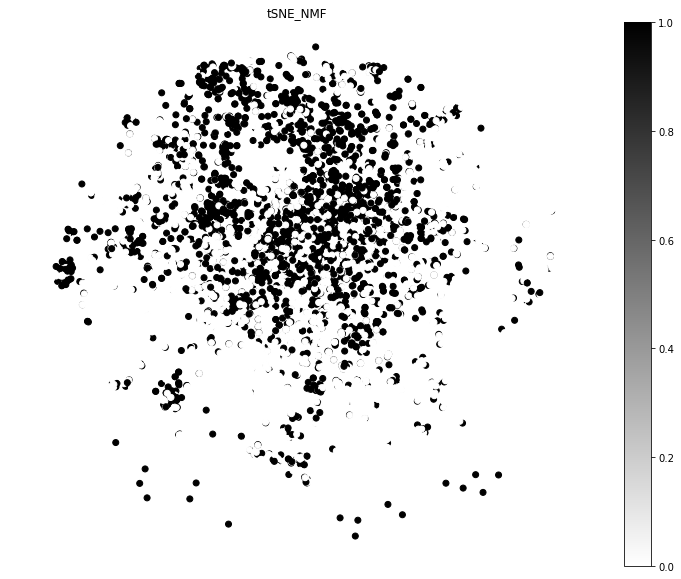

In [46]:
fig = plt.figure(figsize=(13, 10))
fig.patch.set_facecolor('w')
#plt.figure(figsize=(13, 10))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=color_nmf, cmap="binary")
plt.title('tSNE_NMF')
plt.axis('off')
plt.colorbar()
plt.show()
